# 1. Libraries 
## Additional libraries
* arff - library to export dataset to arff files usable by MOA  
  https://pypi.org/project/arff/  
* imblearn - library for dealing with imbalanced datasets (in general, we won't need it in case of artificially created TEP datasets)
  https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html

In [1]:
import glob
# import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

# 2. Dataset
Gather the data and create single dataset which can be later divided into training/testing.

In [2]:
# read all files
base_path = '#datasets'
paths = glob.glob(f'{base_path}/Tennessee_Event-Driven/datasets/d*.dat')
paths.sort()
# create a list of corresponding fault ids (there are 2 files train/test per each fault)
fault_ids = [i for i in range(22) for _ in range(2)]
# I extracted the columns/features names from Harward TEP dataset
col_names = ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 
             'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
             'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
             'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 
             'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
             'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
             'xmv_10', 'xmv_11']

In [3]:
data = np.empty([0,52])
id_col = []
for file,fault_id in zip(paths,fault_ids):
    data_temp = np.genfromtxt(file)
    # d00.dat file is rotated - 52 rows/480 columns, all other files have 52 columns and 480/960 rows (train/test)
    if 'd00.dat' in file:
        data_temp = np.rot90(data_temp)
    data = np.vstack((data, data_temp))
    id_col.extend(np.ones(len(data_temp))*fault_id)
dataset = pd.DataFrame(data=data,columns=col_names) 
dataset['fault_id'] = id_col
dataset['fault_id'] = dataset['fault_id'].astype(int)

dataset.to_csv(f'{base_path}/Tennessee_Event-Driven/datasets/dataset.csv',index=False)

# 3. Drop NA values

In [4]:
print('Fraction of NA values : ' + str(dataset.isna().values.sum()/len(dataset)))
dataset.dropna(inplace=True)

Fraction of NA values : 0.0


# 4. Check if the dataset is balanced - i.e. ~same number of samples per fault_id

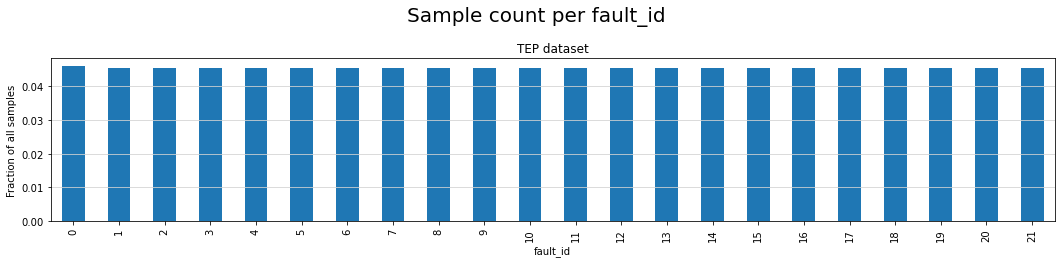

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Sample count per fault_id', size=20, y=1.12)

def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    #ax.set_ylim([0,0.55])
    ax.set_xlabel('fault_id')
    ax.set_ylabel('Fraction of all samples')
    
dataset['fault_id'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax)
applyPlotStyle(ax)
ax.set_title('TEP dataset');

## 4.1. Simple random under/over-sampling to overcome the imbalance

In [6]:
# define undersample strategy
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
# 'not minority' = resample all classes to the size of minority class
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

undersample = RandomUnderSampler(sampling_strategy='not minority')
oversample = RandomOverSampler(sampling_strategy='not majority')

dataset_under, labels_under = undersample.fit_resample(dataset[col_names], dataset['fault_id'])
dataset_over, labels_over = oversample.fit_resample(dataset[col_names], dataset['fault_id'])

dataset_under = pd.DataFrame(data=dataset_under,columns=col_names) 
dataset_under['fault_id'] = dataset['fault_id'].copy()

dataset_over = pd.DataFrame(data=dataset_over,columns=col_names) 
dataset_over['fault_id'] = dataset['fault_id'].copy()

# 5. Standard-scale the dataset for further processing

In [7]:
scaler = StandardScaler()
# scale only samples not fault_ids
scaler.fit(dataset[col_names])
dataset_scaled = pd.DataFrame(scaler.transform(dataset[col_names]),columns=col_names)
dataset_scaled['fault_id'] = dataset['fault_id'].copy()
dataset_scaled.to_csv(f'{base_path}/Tennessee_Event-Driven/datasets/dataset_standard_scaled.csv',index=False)
# create arff file for MOA
# arff.dump('Tennessee_Event-Driven/datasets/dataset_standard_scaled.arff', dataset_scaled.values, relation="TEP DATASET", names=dataset_scaled.columns.values)

# 6. Dataset feature selection/analysis
We use original dataset - daaset before scaling. Scaling removes variance from features. Variance analysis is part of this section.

## 6.1 Visual check of features distribution per fault_id
Idea : Visually check distributions of features to gain idea if some features are better candidates for ML.

C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:394: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


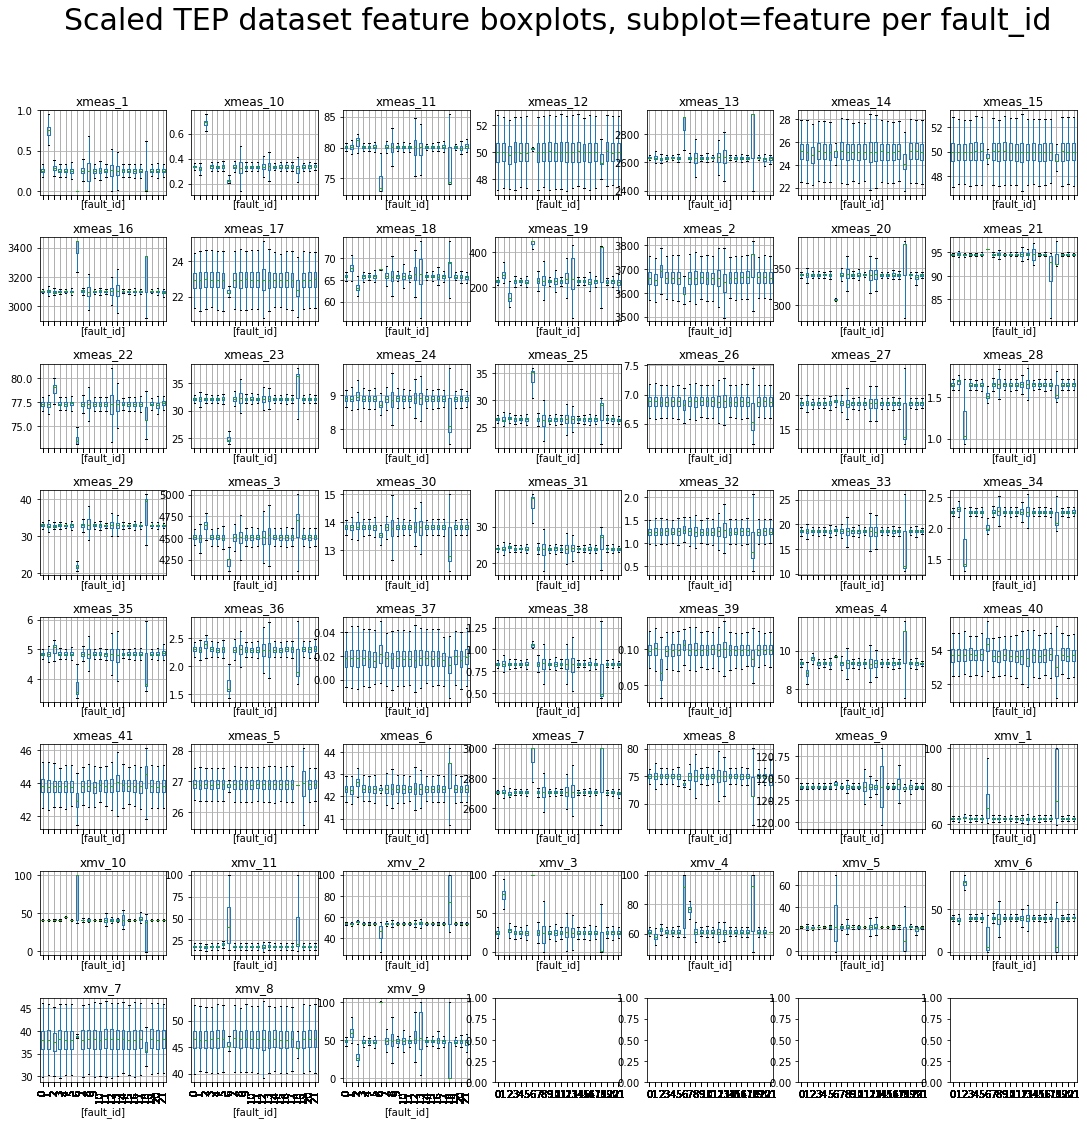

In [8]:
# it's f*cked up, but I have to pass exact number of ax to boxplot otherwise I am unable 
# to have separate y-axis for each subplot
fig, ax = plt.subplots(8,7, figsize=(18, 18),sharey=False, sharex=True)
ax = np.delete(ax.flatten(), [55,54,53,52])
dataset.boxplot(ax=ax, by='fault_id', rot=90, showfliers=False)
fig.suptitle("Scaled TEP dataset feature boxplots, subplot=feature per fault_id", size=30);
plt.subplots_adjust(hspace = 0.5);

## 6.2 Cross correlation of the features
Idea : remove redundant features  
You may change the correlation_threshold to filter out features that have correlation above certain value. 

In [9]:
# do not correlate fault_ids :)
samples = dataset[dataset.columns[:-1]]

dataset_corr = samples.corr()
correlation_threshold = 0.8
upper = dataset_corr.where(np.triu(np.ones(dataset_corr.shape), k = 1).astype(np.bool))
# Select the features with correlations above the threshold
# absolute value - positive/negative correlation
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

C:\Users\Alex\AppData\Local\Temp/ipykernel_29092/2414294766.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = dataset_corr.where(np.triu(np.ones(dataset_corr.shape), k = 1).astype(np.bool))


In [10]:
# Dataframe to hold correlated pairs
dataset_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

# Iterate through the "columns to drop" to record pairs of correlated features
for column in to_drop:

    # Find the correlated features
    corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

    # Find the correlated values
    corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(corr_features))]    

    # Record the information (need a temp df for now)
    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                     'corr_feature': corr_features,
                                     'corr_value': corr_values})
    dataset_collinear = dataset_collinear.append(temp_df, ignore_index = True)
    
dataset_corr_filtered = dataset_corr.loc[list(set(dataset_collinear['corr_feature'])), list(set(dataset_collinear['drop_feature']))]

C:\Users\Alex\AppData\Local\Temp/ipykernel_29092/2877068405.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('Tennessee_Event-Driven/results/features_colinearity.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)


FileNotFoundError: [Errno 2] No such file or directory: 'Tennessee_Event-Driven/results/features_colinearity.pdf'

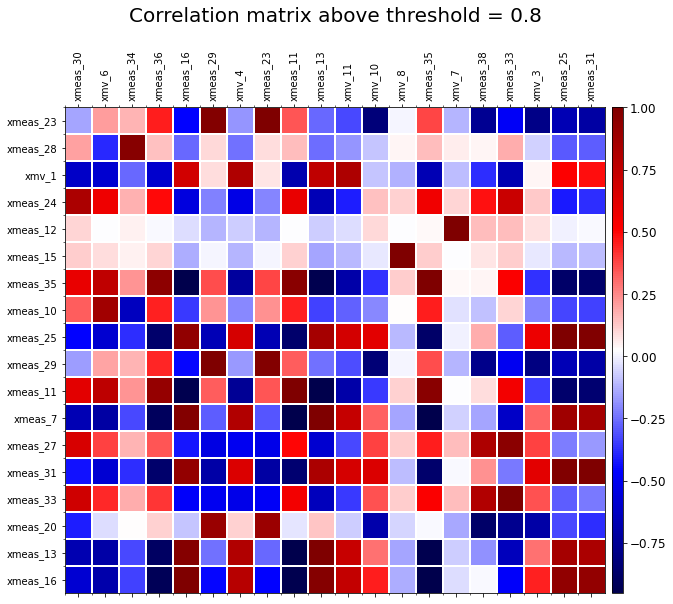

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig.suptitle('Correlation matrix above threshold = ' + str(correlation_threshold), size=20)

heatmap = ax.matshow(dataset_corr_filtered, cmap=plt.cm.seismic)
ax.set_xticks(range(dataset_corr_filtered.shape[1]))
ax.set_xticklabels(dataset_corr_filtered.columns.values, fontsize=10, rotation=90)
ax.set_yticks(range(dataset_corr_filtered.shape[0]))
ax.set_yticklabels(dataset_corr_filtered.index.values, fontsize=10)

ax.set_xticks(np.arange(-.5, dataset_corr_filtered.shape[1]-1, 1), minor=True);
ax.set_yticks(np.arange(-.5, dataset_corr_filtered.shape[0]-1, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=2.)
      
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

cb = fig.colorbar(heatmap, cax=cax)
cb.ax.tick_params(labelsize=12)
fig.savefig('Tennessee_Event-Driven/results/features_colinearity.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

## 6.3. Variance of the features
Idea : remove features with low/zero variance -> most likely bad candidates for ML.

In [ ]:
dataset_std = dataset.std().to_frame().rename(columns = {'index': 'feature', 0: 'std'})
dataset_std = dataset_std.sort_values('std', ascending = False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
fig.suptitle('Sorted features by their variance', size=20)
bar_plot = dataset_std.plot.bar(ax=ax, legend=False, color ='black', width=0.6)
ax.tick_params(labelsize=12)
ax.set_xlabel('sorted features',size=12)
#ax.set_ylabel('std',size=12)
fig.savefig('Tennessee_Event-Driven/results/feature_variance.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

## 6.4. Other feature selection methods algorithms
http://featureselection.asu.edu/

In [ ]:
dataset = pd.read_csv('Tennessee_Event-Driven/datasets/dataset.csv',index_col=False)

### 6.4.1. LAP score [example]

In [ ]:
from skfeature.function.similarity_based import lap_score

dataset_lap_score = lap_score.lap_score(dataset.values)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
first = 0
last = len(dataset.columns)-1
ax.bar(np.arange(dataset.shape[1])[first:last],np.sort(dataset_lap_score)[first:last], color ='black', width=0.8)
ax.tick_params(labelsize=10)
ax.set_ylim([0,1])
ax.set_xlim([-0.5,last-first-0.5])
ax.set_xticks(np.arange(dataset.shape[1])[first:last])
ax.set_xticklabels(dataset.columns.values[np.argsort(dataset_lap_score)][first:last], rotation=90)
    

In [ ]:
from skfeature.function.similarity_based import lap_score

dataset_lap_score = lap_score.lap_score(dataset.values)

## 6.4.x OTHER scores
http://featureselection.asu.edu/algorithms.php